# Visualización de Representaciones Latentes con Autoencoder y UMAP

En este proyecto, entrenamos un autoencoder para aprender representaciones latentes de imágenes. Usamos DBSCAN para agrupar las latentes y UMAP para visualizarlas en un espacio de 2 dimensiones. También incluimos la proyección de nuevas imágenes al espacio generado.

In [3]:
#Librerías y setup inicial

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import DBSCAN
import umap
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import defaultdict
import joblib  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

Usando dispositivo: cpu


In [4]:
#Preparación de datos

class CustomImageDataset(Dataset):

    """
    Clase personalizada para cargar imágenes desde una carpeta.
    - img_dir: Ruta de la carpeta con imágenes
    - transform: Transformaciones a aplicar a las imágenes
    """

    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        try:
            image = Image.open(img_path).convert('RGB')  
            if self.transform:
                image = self.transform(image)
            return image
        except Exception as e:
            print(f"Error al cargar la imagen {self.image_files[idx]}: {e}")
            return torch.zeros(1, 64, 64)  

#Ruta a la carpeta con el dataset que se va a usar
img_dir = "/Users/gabriel/Desktop/Pruebas/Cuántica/Superposición"

# Verificar si la carpeta existe
if not os.path.exists(img_dir):
    raise FileNotFoundError(f"La carpeta especificada no existe: {img_dir}")

# Crear el dataset y el dataloader
dataset = CustomImageDataset(img_dir=img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

In [5]:
#Definimos el modelo Autoencoder

class Autoencoder(nn.Module):

    """
    Autoencoder con codificador y decodificador.
    - latent_dim: Dimensión del espacio latente
    """

    def __init__(self, latent_dim=128):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 8 * 8),
            nn.ReLU(True),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  
            nn.Tanh()
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [6]:
#Configuración del entrenamiento

latent_dim = 128
learning_rate = 1e-3
num_epochs = 10

model = Autoencoder(latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in dataloader:
        img = data.to(device)
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * img.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sample = img[:8]
            reconstructed = model(sample)
        sample = sample.cpu().numpy()
        reconstructed = reconstructed.cpu().numpy()
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            axes[0, i].imshow(sample[i].squeeze(), cmap='gray')  
            axes[0, i].axis('off')
            axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')  
            axes[1, i].axis('off')
        plt.show()



Epoch [1/10], Loss: 0.0433


KeyboardInterrupt: 

In [7]:
#Guardar el modelo y extraer las representaciones latentes

torch.save(model.state_dict(), 'autoencoder.pth')
print("Modelo guardado como 'autoencoder.pth'")

dataloader_no_shuffle = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)  
model.eval()

latent_representations = []
image_filenames = []

with torch.no_grad():
    for data in dataloader_no_shuffle:
        img = data.to(device)
        latent = model.encoder(img)
        latent = latent.cpu().numpy()
        latent_representations.append(latent)

latent_representations = np.concatenate(latent_representations, axis=0)
print(f'Tamaño de las representaciones latentes: {latent_representations.shape}')

dbscan = DBSCAN(eps=5, min_samples=10)
clusters = dbscan.fit_predict(latent_representations)
print(f'Número de clusters encontrados: {len(set(clusters)) - (1 if -1 in clusters else 0)}')


Modelo guardado como 'autoencoder.pth'


KeyboardInterrupt: 

Tamaño del embedding UMAP: (2723, 2)
Modelo UMAP guardado como 'umap_model.joblib'
Embedding UMAP guardado como 'umap_embedding.npy'


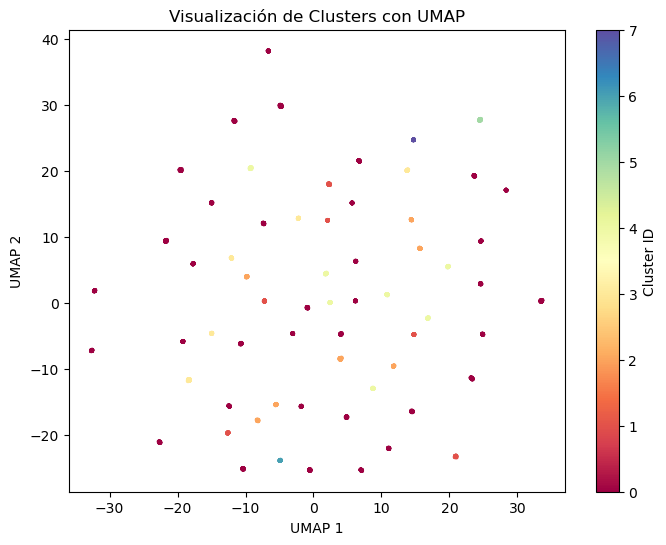

In [179]:
#Visualización con UMAP

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
embedding = reducer.fit_transform(latent_representations)
print(f'Tamaño del embedding UMAP: {embedding.shape}')

umap_model_path = 'umap_model.joblib'
umap_embedding_path = 'umap_embedding.npy'
joblib.dump(reducer, umap_model_path)
np.save(umap_embedding_path, embedding)
print(f"Modelo UMAP guardado como '{umap_model_path}'")
print(f"Embedding UMAP guardado como '{umap_embedding_path}'")

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='Spectral', s=5)
plt.colorbar(scatter, label='Cluster ID')
plt.title('Visualización de Clusters con UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [8]:
#Función para proyectar sobre el UMAP nuevas proyecciones

def project_and_plot_new_image(new_image_path, autoencoder_path='autoencoder.pth',
                               umap_model_path='umap_model.joblib',
                               umap_embedding_path='umap_embedding.npy'):
    import torch
    import torch.nn as nn
    from torchvision import transforms
    from PIL import Image
    import joblib
    import matplotlib.pyplot as plt
    import numpy as np

    class Autoencoder(nn.Module):
        def __init__(self, latent_dim=128):
            super(Autoencoder, self).__init__()
            # Encoder
            self.encoder = nn.Sequential(
                nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Cambia a 3 canales si usas RGB
                nn.ReLU(True),
                nn.Conv2d(16, 32, 3, stride=2, padding=1),
                nn.ReLU(True),
                nn.Conv2d(32, 64, 3, stride=2, padding=1),
                nn.ReLU(True),
                nn.Flatten(),
                nn.Linear(64 * 8 * 8, latent_dim)
            )
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, 64 * 8 * 8),
                nn.ReLU(True),
                nn.Unflatten(1, (64, 8, 8)),
                nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
                nn.ReLU(True),
                nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # Cambia a 3 canales si usas RGB
                nn.Tanh()
            )
        
        def forward(self, x):
            latent = self.encoder(x)
            return latent

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Grayscale(),  
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  
    ])

    def load_autoencoder(model_path, latent_dim=128):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = Autoencoder(latent_dim=latent_dim).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        return model, device

    def load_umap_model(umap_model_path):
        reducer = joblib.load(umap_model_path)
        return reducer

    def load_umap_embedding(umap_embedding_path):
        embedding = np.load(umap_embedding_path)
        return embedding

    def process_image(image_path, transform):
        image = Image.open(image_path).convert('RGB')  
        image = transform(image)
        image = image.unsqueeze(0)  
        return image


    def project_image(image_path, autoencoder, reducer, device):
        image = process_image(image_path, transform).to(device)
        with torch.no_grad():
            latent = autoencoder.encoder(image)
        latent = latent.cpu().numpy()

        embedding = reducer.transform(latent)
        return embedding

    def visualize_projection(embedding, existing_embedding, image_path):
        plt.figure(figsize=(10, 8))
        plt.scatter(existing_embedding[:, 0], existing_embedding[:, 1], c='lightgray', s=5, label='Datos Existentes')
        plt.scatter(embedding[0, 0], embedding[0, 1], c='red', s=100, label='Nueva Imagen')
        plt.legend()
        plt.title('Proyección de Nueva Imagen en el Espacio UMAP')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.show()

    if not os.path.exists(autoencoder_path):
        raise FileNotFoundError(f"No se encontró el archivo del autoencoder: {autoencoder_path}")
    if not os.path.exists(umap_model_path):
        raise FileNotFoundError(f"No se encontró el archivo del modelo UMAP: {umap_model_path}")
    if not os.path.exists(umap_embedding_path):
        raise FileNotFoundError(f"No se encontró el archivo del embedding UMAP: {umap_embedding_path}")
    if not os.path.exists(new_image_path):
        raise FileNotFoundError(f"No se encontró la imagen especificada: {new_image_path}")

    autoencoder, device = load_autoencoder(autoencoder_path, latent_dim=128)
    reducer = load_umap_model(umap_model_path)
    existing_embedding = load_umap_embedding(umap_embedding_path)

    embedding = project_image(new_image_path, autoencoder, reducer, device)
    print(f'Coordenadas UMAP de la nueva imagen: {embedding}')

    visualize_projection(embedding, existing_embedding, new_image_path)


In [9]:
#Selección de la nueva imagen a proyectar en el UMAP

nueva_imagen_path = 'Pruebas/acreenahot_1523.png' 

project_and_plot_new_image(nueva_imagen_path)


/var/folders/lm/_fxc20xx06sgw5x65ymlkp600000gn/T/ipykernel_30392/856241281.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

KeyboardInterrupt: 